In [2]:
# from spacy_langdetect import LanguageDetector
# from spacy.language import Language
# import spacy
import pandas as pd
from frequentist_treatment_nlp import *
import nltk
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, mean_squared_error
from nltk.stem.snowball import SnowballStemmer
import regex
import re
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,GRU,LSTM,Embedding, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SpatialDropout1D,Dropout,Bidirectional,Conv1D,GlobalMaxPooling1D, MaxPooling1D, LeakyReLU, Flatten, InputLayer, Input, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping, History
import tensorflow as tf
from sklearn.manifold import TSNE
from tensorflow.keras.backend import clear_session

In [3]:
tf.config.list_physical_devices()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [4]:
path = 'C:/Users/32mor/OneDrive/Documents/Polytechnique/NLP & Natixis/starting_kit/data'

In [5]:
path = 'C:/Users/32mor/OneDrive/Documents/Polytechnique/NLP & Natixis/starting_kit/data'
os.chdir(path)
X, y_cat, y_reg = hx.data_expander(all_data=True,index='eur')
y = pd.concat([y_cat,y_reg],axis=1)

In [7]:
pipe_num = numerical_pipeline(ema=True, lstm=True)

In [11]:
unsaved  = True
if unsaved:
     print('unsaved')
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
     pipe_ecb = Full_pipeline_nlp('ecb', 0.3, 300,translate=False)
     pipe_fed = Full_pipeline_nlp('fed',0.3, 300, translate=False)
     pipe_num = numerical_pipeline(ema=True, lstm=True)
     test_pipe  = full_pipeline(pipe_fed, pipe_ecb, pipe_num)
     X_fed_train, X_ecb_train, X_num_train = test_pipe.fit_transform(X_train)
     X_fed_val, X_ecb_val, X_num_val = test_pipe.transform(X_val)
     X_fed_test, X_ecb_test, X_num_test = test_pipe.transform(X_test)


     y_train_reg = y_train.target_reg
     y_train_cat = y_train.target_classif
     y_test_reg = y_test.target_reg
     y_test_cat = y_test.target_classif
     y_val_reg = y_val.target_reg
     y_val_cat = y_val.target_classif
     os.chdir(path)
     saves = [X_fed_train, X_fed_test, X_fed_val, X_ecb_train, X_ecb_test, 
                    X_ecb_val, X_num_train,X_num_test, X_num_val, y_test_cat,
                    y_test_reg, y_train_reg, y_train_cat, y_val_cat, y_val_reg]
     for element in saves:
          vnames = [name for name in globals() if globals()[name] is element][0]
          np.save(f'{vnames}_eurusd.npy',element)

else:
     print('saved')
     for element in os.listdir():
          if 'npy' in element :
               if element not in ['element.npy','__.npy']:
                    str = element
                    globals()[str.split('.')[0]] = np.load(element)

day_max = 20
speeches_train = int(len(X_fed_train)/20)
speeches_val = int(len(X_ecb_val)/20)
speeches_test = int(len(X_ecb_test)/20)
components = 300
X_fed_lstm_train = X_fed_train.reshape((speeches_train, day_max, components))
X_ecb_lstm_train = X_ecb_train.reshape((speeches_train, day_max, components))
X_fed_lstm_test = X_fed_test.reshape((speeches_test, day_max, components))
X_ecb_lstm_test = X_ecb_test.reshape((speeches_test, day_max, components))
X_fed_lstm_val = X_fed_val.reshape((speeches_val, day_max, components))
X_ecb_lstm_val = X_ecb_val.reshape((speeches_val, day_max, components))
lstm_shape = (day_max, components)
shape_num = day_max

unsaved


100%|██████████| 1050/1050 [00:00<00:00, 27037.10it/s]


In [12]:
shape_num = (day_max,2)

In [13]:
def multi_input_output_lstm_full(shape_nlp, shape_num):
    input_nlp_fed = Input(shape=(shape_nlp[0], shape_nlp[1]))
    input_nlp_bce = Input(shape=(shape_nlp[0], shape_nlp[1]))
    input_num = Input(shape=(shape_num[0], shape_num[1]))


    w = LSTM(100, return_sequences=True)(input_nlp_fed)
    w = Dropout(0.3)(w)
    #w = BatchNormalization()(w)
    w = LSTM(40, return_sequences=False)(w)
    w = Dropout(0.3)(w)
    w = Model(inputs=input_nlp_fed, outputs=w)


    x = LSTM(100, return_sequences=True)(input_nlp_bce)
    x = Dropout(0.3)(x)
    #x = BatchNormalization()(x)
    x = LSTM(40, return_sequences=False)(x)
    #x = Dropout(0.3)(x)
    x = Model(inputs=input_nlp_bce, outputs=x)

    # the second branch opreates on the second input
    y = LSTM(100, return_sequences=False)(input_num)
    y = Dropout(0.3)(y)
    #y = BatchNormalization()(y)
    # y = LSTM(40, return_sequences=False)(y)
    # y = Dropout(0.3)(y)
    y = Model(inputs=input_num, outputs=y)
    # combine the output of the two branches
    combined = concatenate([w.output, x.output, y.output])

    z = Dense(64, activation='relu')(combined)
    z = Dropout(0.3)(z)
    

    out_reg = Dense(1, activation='linear')(z)
    

    classi = BatchNormalization()(z)
    out_class = Dense(1, activation = 'sigmoid')(classi)
    model = Model(inputs=[w.input, x.input, y.input], outputs=[out_reg, out_class])

    return model

In [18]:
import optuna

In [19]:
def objective_full(trial):
    # Clear clutter from previous Keras session graphs.
    clear_session()
    # model = multi_input_output_lstm_full

    # We compile our model with a sampled learning rate.
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    model=multi_input_output_lstm_full(lstm_shape, shape_num)

    early_stop = EarlyStopping(monitor='val_loss', patience=3)
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss=['mse',tf.keras.losses.binary_crossentropy], 
                    optimizer=optimizer)

    history = model.fit([X_fed_lstm_train, X_ecb_lstm_train, X_num_train], 
                        [y_train_reg,y_train_cat], 
                        epochs=50, 
                        batch_size=128, verbose=2,
                        callbacks=[early_stop, tensorboard_callback, ], 
                        validation_data=([X_fed_lstm_val,X_ecb_lstm_val, X_num_val],[y_val_reg,y_val_cat]))


    # Evaluate the model accuracy on the validation set.
    score = model.evaluate([X_fed_lstm_val,X_ecb_lstm_val, X_num_val],[y_val_reg,y_val_cat], verbose=0)
    return score[1]


In [20]:
import datetime

In [21]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_full, n_trials=4, timeout=None)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

[I 2022-03-28 22:05:06,257] A new study created in memory with name: no-name-a74bc54d-73a4-4fe4-b47b-48083777fdec


Epoch 1/50
8/8 - 23s - loss: 1.6017 - dense_1_loss: 0.7553 - dense_2_loss: 0.8463 - val_loss: 1.0597 - val_dense_1_loss: 0.3632 - val_dense_2_loss: 0.6966
Epoch 2/50
8/8 - 4s - loss: 1.0924 - dense_1_loss: 0.3809 - dense_2_loss: 0.7115 - val_loss: 0.9159 - val_dense_1_loss: 0.2222 - val_dense_2_loss: 0.6937
Epoch 3/50
8/8 - 3s - loss: 0.9542 - dense_1_loss: 0.3003 - dense_2_loss: 0.6540 - val_loss: 0.8976 - val_dense_1_loss: 0.2032 - val_dense_2_loss: 0.6944
Epoch 4/50
8/8 - 3s - loss: 0.8928 - dense_1_loss: 0.2590 - dense_2_loss: 0.6338 - val_loss: 0.8866 - val_dense_1_loss: 0.1866 - val_dense_2_loss: 0.7000
Epoch 5/50
8/8 - 3s - loss: 0.8054 - dense_1_loss: 0.2545 - dense_2_loss: 0.5509 - val_loss: 0.8888 - val_dense_1_loss: 0.1830 - val_dense_2_loss: 0.7058
Epoch 6/50
8/8 - 3s - loss: 0.7533 - dense_1_loss: 0.2516 - dense_2_loss: 0.5017 - val_loss: 0.8814 - val_dense_1_loss: 0.1804 - val_dense_2_loss: 0.7009
Epoch 7/50
8/8 - 3s - loss: 0.6882 - dense_1_loss: 0.2319 - dense_2_loss: 0

[I 2022-03-28 22:06:17,081] Trial 0 finished with value: 0.1956726610660553 and parameters: {'learning_rate': 0.0007997737986483937}. Best is trial 0 with value: 0.1956726610660553.


Epoch 1/50
8/8 - 13s - loss: 1.7902 - dense_1_loss: 0.9655 - dense_2_loss: 0.8247 - val_loss: 1.1955 - val_dense_1_loss: 0.5036 - val_dense_2_loss: 0.6919
Epoch 2/50
8/8 - 2s - loss: 1.1867 - dense_1_loss: 0.4853 - dense_2_loss: 0.7014 - val_loss: 0.9698 - val_dense_1_loss: 0.2690 - val_dense_2_loss: 0.7008
Epoch 3/50
8/8 - 3s - loss: 1.0437 - dense_1_loss: 0.3280 - dense_2_loss: 0.7158 - val_loss: 0.9585 - val_dense_1_loss: 0.2563 - val_dense_2_loss: 0.7022
Epoch 4/50
8/8 - 2s - loss: 1.0009 - dense_1_loss: 0.3205 - dense_2_loss: 0.6804 - val_loss: 0.9141 - val_dense_1_loss: 0.2149 - val_dense_2_loss: 0.6992
Epoch 5/50
8/8 - 3s - loss: 0.9244 - dense_1_loss: 0.2854 - dense_2_loss: 0.6389 - val_loss: 0.8944 - val_dense_1_loss: 0.1960 - val_dense_2_loss: 0.6984
Epoch 6/50
8/8 - 3s - loss: 0.8893 - dense_1_loss: 0.2671 - dense_2_loss: 0.6222 - val_loss: 0.8832 - val_dense_1_loss: 0.1846 - val_dense_2_loss: 0.6985
Epoch 7/50
8/8 - 3s - loss: 0.7788 - dense_1_loss: 0.2316 - dense_2_loss: 0

[I 2022-03-28 22:07:03,297] Trial 1 finished with value: 0.18192340433597565 and parameters: {'learning_rate': 0.0005086025450915318}. Best is trial 0 with value: 0.1956726610660553.


Epoch 1/50
8/8 - 13s - loss: 1.8195 - dense_1_loss: 0.9873 - dense_2_loss: 0.8322 - val_loss: 1.4906 - val_dense_1_loss: 0.7998 - val_dense_2_loss: 0.6908
Epoch 2/50
8/8 - 3s - loss: 1.4901 - dense_1_loss: 0.7014 - dense_2_loss: 0.7887 - val_loss: 1.2877 - val_dense_1_loss: 0.5977 - val_dense_2_loss: 0.6900
Epoch 3/50
8/8 - 2s - loss: 1.3137 - dense_1_loss: 0.5907 - dense_2_loss: 0.7229 - val_loss: 1.1347 - val_dense_1_loss: 0.4425 - val_dense_2_loss: 0.6922
Epoch 4/50
8/8 - 3s - loss: 1.0984 - dense_1_loss: 0.4245 - dense_2_loss: 0.6738 - val_loss: 1.0191 - val_dense_1_loss: 0.3244 - val_dense_2_loss: 0.6947
Epoch 5/50
8/8 - 3s - loss: 1.0110 - dense_1_loss: 0.3338 - dense_2_loss: 0.6772 - val_loss: 0.9503 - val_dense_1_loss: 0.2532 - val_dense_2_loss: 0.6971
Epoch 6/50
8/8 - 2s - loss: 0.9492 - dense_1_loss: 0.2928 - dense_2_loss: 0.6563 - val_loss: 0.9273 - val_dense_1_loss: 0.2286 - val_dense_2_loss: 0.6987
Epoch 7/50
8/8 - 3s - loss: 0.9468 - dense_1_loss: 0.2871 - dense_2_loss: 0

[I 2022-03-28 22:07:56,746] Trial 2 finished with value: 0.19617411494255066 and parameters: {'learning_rate': 0.00021663305093458883}. Best is trial 2 with value: 0.19617411494255066.


Epoch 1/50
8/8 - 12s - loss: 2.0862 - dense_1_loss: 1.1831 - dense_2_loss: 0.9031 - val_loss: 1.9673 - val_dense_1_loss: 1.2653 - val_dense_2_loss: 0.7019
Epoch 2/50
8/8 - 3s - loss: 2.0382 - dense_1_loss: 1.1522 - dense_2_loss: 0.8860 - val_loss: 1.9319 - val_dense_1_loss: 1.2302 - val_dense_2_loss: 0.7017
Epoch 3/50
8/8 - 3s - loss: 1.9886 - dense_1_loss: 1.1185 - dense_2_loss: 0.8701 - val_loss: 1.9010 - val_dense_1_loss: 1.1995 - val_dense_2_loss: 0.7014
Epoch 4/50
8/8 - 3s - loss: 1.9540 - dense_1_loss: 1.1017 - dense_2_loss: 0.8523 - val_loss: 1.8715 - val_dense_1_loss: 1.1702 - val_dense_2_loss: 0.7012
Epoch 5/50
8/8 - 3s - loss: 1.9548 - dense_1_loss: 1.1027 - dense_2_loss: 0.8521 - val_loss: 1.8433 - val_dense_1_loss: 1.1422 - val_dense_2_loss: 0.7011
Epoch 6/50
8/8 - 3s - loss: 1.9388 - dense_1_loss: 1.0743 - dense_2_loss: 0.8645 - val_loss: 1.8156 - val_dense_1_loss: 1.1148 - val_dense_2_loss: 0.7008
Epoch 7/50
8/8 - 3s - loss: 1.8452 - dense_1_loss: 1.0217 - dense_2_loss: 0

[I 2022-03-28 22:10:28,733] Trial 3 finished with value: 0.4381687045097351 and parameters: {'learning_rate': 1.4576432019147325e-05}. Best is trial 3 with value: 0.4381687045097351.


Number of finished trials: 4
Best trial:


In [23]:
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    learning_rate = value

    learning_rate: 1.4576432019147325e-05


In [25]:
model=multi_input_output_lstm_full(lstm_shape, shape_num)
early_stop = EarlyStopping(monitor='val_loss', patience=3)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss=['mse',tf.keras.losses.binary_crossentropy], optimizer=optimizer)

In [26]:
history = model.fit([X_fed_lstm_train, X_ecb_lstm_train, X_num_train], [y_train_reg,y_train_cat], epochs=50, batch_size=256, verbose=2,
         callbacks=[early_stop, tensorboard_callback, ], 
         validation_data=([X_fed_lstm_val,X_ecb_lstm_val, X_num_val],[y_val_reg,y_val_cat]))

Epoch 1/50
4/4 - 16s - loss: 2.1561 - dense_4_loss: 1.2660 - dense_5_loss: 0.8902 - val_loss: 2.0176 - val_dense_4_loss: 1.3321 - val_dense_5_loss: 0.6855
Epoch 2/50
4/4 - 3s - loss: 2.0602 - dense_4_loss: 1.2154 - dense_5_loss: 0.8449 - val_loss: 1.9943 - val_dense_4_loss: 1.3088 - val_dense_5_loss: 0.6855
Epoch 3/50
4/4 - 3s - loss: 2.0785 - dense_4_loss: 1.1856 - dense_5_loss: 0.8930 - val_loss: 1.9720 - val_dense_4_loss: 1.2865 - val_dense_5_loss: 0.6855
Epoch 4/50
4/4 - 3s - loss: 2.0557 - dense_4_loss: 1.1816 - dense_5_loss: 0.8741 - val_loss: 1.9508 - val_dense_4_loss: 1.2653 - val_dense_5_loss: 0.6855
Epoch 5/50
4/4 - 3s - loss: 2.0015 - dense_4_loss: 1.1196 - dense_5_loss: 0.8819 - val_loss: 1.9299 - val_dense_4_loss: 1.2444 - val_dense_5_loss: 0.6855
Epoch 6/50
4/4 - 4s - loss: 1.9764 - dense_4_loss: 1.1321 - dense_5_loss: 0.8444 - val_loss: 1.9089 - val_dense_4_loss: 1.2235 - val_dense_5_loss: 0.6855
Epoch 7/50
4/4 - 3s - loss: 2.0222 - dense_4_loss: 1.1455 - dense_5_loss: 0

In [28]:
model.evaluate([X_fed_lstm_val,X_ecb_lstm_val, X_num_val],[y_val_reg,y_val_cat], verbose=0)

[1.298182725906372, 0.6132282018661499, 0.6849546432495117]

In [27]:
model.save("mutli_inouts_outputs_model_eurusd")

INFO:tensorflow:Assets written to: mutli_inouts_outputs_model_eurusd\assets


INFO:tensorflow:Assets written to: mutli_inouts_outputs_model_eurusd\assets


In [37]:
def multi_input_class_lstm_full(shape_nlp, shape_num):
    input_nlp_fed = Input(shape=(shape_nlp[0], shape_nlp[1]))
    input_nlp_bce = Input(shape=(shape_nlp[0], shape_nlp[1]))
    input_num = Input(shape=shape_num)


    w = LSTM(100, return_sequences=True)(input_nlp_fed)
    w = Dropout(0.3)(w)
    #w = BatchNormalization()(w)
    w = LSTM(40, return_sequences=False)(w)
    w = Dropout(0.3)(w)
    w = Model(inputs=input_nlp_fed, outputs=w)


    x = LSTM(100, return_sequences=True)(input_nlp_bce)
    x = Dropout(0.3)(x)
    #x = BatchNormalization()(x)
    x = LSTM(40, return_sequences=False)(x)
    #x = Dropout(0.3)(x)
    x = Model(inputs=input_nlp_bce, outputs=x)

    # the second branch opreates on the second input
    y = LSTM(100, return_sequences=False)(input_num)
    y = Dropout(0.3)(y)
    #y = BatchNormalization()(y)
    # y = LSTM(40, return_sequences=False)(y)
    # y = Dropout(0.3)(y)
    y = Model(inputs=input_num, outputs=y)
    # combine the output of the two branches
    combined = concatenate([w.output, x.output, y.output])

    z = Dense(64, activation='relu')(combined)
    z = Dropout(0.3)(z)
    classi = BatchNormalization()(z)
    classi = Dense(64)(classi)
    classi = LeakyReLU(0.3)(classi)
    classi = Dropout(0.5)(classi)
    z = Dense(64, activation='relu')(z)
    z = Dropout(0.3)(z)
    out_reg = Dense(1, activation='linear')(z)
    
    out_class = Dense(1, activation = 'sigmoid')(z)
    model = Model(inputs=[w.input, x.input, y.input], outputs=out_class)

    return model

In [46]:
from sklearn.metrics import accuracy_score

In [68]:
def objective_class(trial):
    # Clear clutter from previous Keras session graphs.
    clear_session()

    # We compile our model with a sampled learning rate.
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    model=multi_input_class_lstm_full(lstm_shape, shape_num)

    early_stop = EarlyStopping(monitor='val_loss', patience=3)
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss=tf.keras.losses.binary_crossentropy, 
                    optimizer=optimizer)

    history = model.fit([X_fed_lstm_train, X_ecb_lstm_train, X_num_train], 
                        y_train_cat,
                        epochs=50, 
                        batch_size=128, verbose=2,
                        callbacks=[early_stop, tensorboard_callback, ], 
                        validation_data=([X_fed_lstm_val,X_ecb_lstm_val, X_num_val],y_val_cat))


    # Evaluate the model accuracy on the validation set.
    y_pred = model.predict([X_fed_lstm_test,X_ecb_lstm_test, X_num_test])
    score = accuracy_score(y_test_cat, (y_pred)>=0.5)
    return score


In [69]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_class, n_trials=4, timeout=None)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

[I 2022-03-28 22:42:26,212] A new study created in memory with name: no-name-d29fea1d-47ac-4863-9da9-5045ac6b6b79


Epoch 1/50
8/8 - 14s - loss: 0.7065 - val_loss: 0.6912
Epoch 2/50
8/8 - 3s - loss: 0.6937 - val_loss: 0.7211
Epoch 3/50
8/8 - 3s - loss: 0.6863 - val_loss: 0.7823
Epoch 4/50
8/8 - 3s - loss: 0.6860 - val_loss: 0.7066


[I 2022-03-28 22:42:55,068] Trial 0 finished with value: 0.5537848605577689 and parameters: {'learning_rate': 0.013049696474121502}. Best is trial 0 with value: 0.5537848605577689.


Epoch 1/50
8/8 - 14s - loss: 0.6894 - val_loss: 0.7019
Epoch 2/50
8/8 - 3s - loss: 0.6717 - val_loss: 0.7082
Epoch 3/50
8/8 - 3s - loss: 0.6581 - val_loss: 0.7003
Epoch 4/50
8/8 - 3s - loss: 0.6331 - val_loss: 0.7240
Epoch 5/50
8/8 - 3s - loss: 0.5500 - val_loss: 0.8024
Epoch 6/50
8/8 - 3s - loss: 0.4491 - val_loss: 1.0177


[I 2022-03-28 22:43:28,735] Trial 1 finished with value: 0.5378486055776892 and parameters: {'learning_rate': 0.0012744188353801748}. Best is trial 0 with value: 0.5537848605577689.


Epoch 1/50
8/8 - 13s - loss: 0.6820 - val_loss: 0.7054
Epoch 2/50
8/8 - 3s - loss: 0.6790 - val_loss: 0.6987
Epoch 3/50
8/8 - 3s - loss: 0.6641 - val_loss: 0.6964
Epoch 4/50
8/8 - 3s - loss: 0.6566 - val_loss: 0.6906
Epoch 5/50
8/8 - 3s - loss: 0.6481 - val_loss: 0.6931
Epoch 6/50
8/8 - 3s - loss: 0.6259 - val_loss: 0.6939
Epoch 7/50
8/8 - 2s - loss: 0.5926 - val_loss: 0.7132


[I 2022-03-28 22:44:03,374] Trial 2 finished with value: 0.5537848605577689 and parameters: {'learning_rate': 0.0006421828924535239}. Best is trial 0 with value: 0.5537848605577689.


Epoch 1/50
8/8 - 14s - loss: 0.6985 - val_loss: 0.6915
Epoch 2/50
8/8 - 3s - loss: 0.6856 - val_loss: 0.7229
Epoch 3/50
8/8 - 3s - loss: 0.6807 - val_loss: 0.6959
Epoch 4/50
8/8 - 3s - loss: 0.6303 - val_loss: 0.8052


[I 2022-03-28 22:44:31,735] Trial 3 finished with value: 0.5856573705179283 and parameters: {'learning_rate': 0.0047346144099486035}. Best is trial 3 with value: 0.5856573705179283.


Number of finished trials: 4
Best trial:


In [70]:
print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    learning_rate = value

  Value: 0.5856573705179283
  Params: 
    learning_rate: 0.0047346144099486035


In [71]:
model_cat=multi_input_class_lstm_full(lstm_shape, shape_num)
early_stop = EarlyStopping(monitor='val_loss', patience=3)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
optimizer = Adam(learning_rate=learning_rate)
model_cat.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=optimizer)
history = model_cat.fit([X_fed_lstm_train, X_ecb_lstm_train, X_num_train], y_train_cat, epochs=50, batch_size=128, verbose=2,
    validation_data = ([X_fed_lstm_val, X_ecb_lstm_val, X_num_val], y_val_cat), callbacks=[early_stop, tensorboard_callback, ])

Epoch 1/50
8/8 - 17s - loss: 0.7038 - val_loss: 0.6964
Epoch 2/50
8/8 - 3s - loss: 0.6823 - val_loss: 0.6907
Epoch 3/50
8/8 - 3s - loss: 0.6683 - val_loss: 0.6884
Epoch 4/50
8/8 - 3s - loss: 0.6084 - val_loss: 0.9618
Epoch 5/50
8/8 - 3s - loss: 0.4827 - val_loss: 0.9019
Epoch 6/50
8/8 - 3s - loss: 0.4098 - val_loss: 1.0448


In [72]:
model_cat.save("multi_inputs_class_model_eurusd")

INFO:tensorflow:Assets written to: multi_inputs_class_model_eurusd\assets


INFO:tensorflow:Assets written to: multi_inputs_class_model_eurusd\assets


In [75]:
def multi_input_reg_lstm_full(shape_nlp, shape_num):
    input_nlp_fed = Input(shape=(shape_nlp[0], shape_nlp[1]))
    input_nlp_bce = Input(shape=(shape_nlp[0], shape_nlp[1]))
    input_num = Input(shape=shape_num)


    w = LSTM(100, return_sequences=True)(input_nlp_fed)
    w = Dropout(0.3)(w)
    #w = BatchNormalization()(w)
    w = LSTM(40, return_sequences=False)(w)
    w = Dropout(0.3)(w)
    w = Model(inputs=input_nlp_fed, outputs=w)


    x = LSTM(100, return_sequences=True)(input_nlp_bce)
    x = Dropout(0.3)(x)
    #x = BatchNormalization()(x)
    x = LSTM(40, return_sequences=False)(x)
    #x = Dropout(0.3)(x)
    x = Model(inputs=input_nlp_bce, outputs=x)

    # the second branch opreates on the second input
    y = LSTM(100, return_sequences=False)(input_num)
    y = Dropout(0.3)(y)
    #y = BatchNormalization()(y)
    # y = LSTM(40, return_sequences=False)(y)
    # y = Dropout(0.3)(y)
    y = Model(inputs=input_num, outputs=y)
    # combine the output of the two branches
    combined = concatenate([w.output, x.output, y.output])

    z = Dense(64, activation='relu')(combined)
    z = Dropout(0.3)(z)
    # classi = BatchNormalization()(z)
    # classi = Dense(64)(classi)
    # classi = LeakyReLU(0.3)(classi)
    # classi = Dropout(0.5)(classi)
    z = Dense(64, activation='relu')(z)
    z = Dropout(0.3)(z)
    out_reg = Dense(1, activation='linear')(z)
    
    # out_class = Dense(1, activation = 'sigmoid')(z)
    model = Model(inputs=[w.input, x.input, y.input], outputs=out_reg)

    return model

In [76]:
from sklearn.metrics import mean_squared_error

In [77]:
def objective_reg(trial):
    # Clear clutter from previous Keras session graphs.
    clear_session()

    # We compile our model with a sampled learning rate.
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    model=multi_input_reg_lstm_full(lstm_shape, shape_num)

    early_stop = EarlyStopping(monitor='val_loss', patience=3)
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss=['mse'], 
                    optimizer=optimizer)

    history = model.fit([X_fed_lstm_train, X_ecb_lstm_train, X_num_train], 
                        y_train_reg, 
                        epochs=50, 
                        batch_size=128, verbose=2,
                        callbacks=[early_stop, tensorboard_callback, ], 
                        validation_data=([X_fed_lstm_val,X_ecb_lstm_val, X_num_val],y_val_reg))


    # Evaluate the model accuracy on the validation set.
    y_pred = model.predict([X_fed_lstm_test,X_ecb_lstm_test, X_num_test])
    score = mean_squared_error(y_test_reg, y_pred)**(1/2)
    return -score


In [78]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_class, n_trials=4, timeout=None)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

[I 2022-03-28 22:45:44,918] A new study created in memory with name: no-name-bc23b58a-a762-404b-ac76-4f829ae06ec3


Epoch 1/50
8/8 - 18s - loss: 0.6833 - val_loss: 0.6984
Epoch 2/50
8/8 - 3s - loss: 0.6768 - val_loss: 0.6941
Epoch 3/50
8/8 - 3s - loss: 0.6699 - val_loss: 0.6978
Epoch 4/50
8/8 - 3s - loss: 0.6541 - val_loss: 0.7143
Epoch 5/50
8/8 - 3s - loss: 0.6263 - val_loss: 0.7089


[I 2022-03-28 22:46:20,305] Trial 0 finished with value: 0.5617529880478087 and parameters: {'learning_rate': 0.0009633256677424558}. Best is trial 0 with value: 0.5617529880478087.


Epoch 1/50
8/8 - 16s - loss: 3.1618 - val_loss: 0.7401
Epoch 2/50
8/8 - 3s - loss: 0.7455 - val_loss: 0.7226
Epoch 3/50
8/8 - 3s - loss: 0.7237 - val_loss: 0.7037
Epoch 4/50
8/8 - 3s - loss: 0.7035 - val_loss: 0.7010
Epoch 5/50
8/8 - 3s - loss: 0.6870 - val_loss: 0.6982
Epoch 6/50
8/8 - 3s - loss: 0.6947 - val_loss: 0.6962
Epoch 7/50
8/8 - 3s - loss: 0.6890 - val_loss: 0.6986
Epoch 8/50
8/8 - 2s - loss: 0.6864 - val_loss: 0.6988
Epoch 9/50
8/8 - 2s - loss: 0.6850 - val_loss: 0.6999


[I 2022-03-28 22:47:03,373] Trial 1 finished with value: 0.5657370517928287 and parameters: {'learning_rate': 0.09360889900063225}. Best is trial 1 with value: 0.5657370517928287.


Epoch 1/50
8/8 - 20s - loss: 0.6978 - val_loss: 0.6940
Epoch 2/50
8/8 - 3s - loss: 0.6890 - val_loss: 0.6956
Epoch 3/50
8/8 - 3s - loss: 0.6839 - val_loss: 0.6962
Epoch 4/50
8/8 - 3s - loss: 0.6766 - val_loss: 0.6968


[I 2022-03-28 22:47:36,797] Trial 2 finished with value: 0.5657370517928287 and parameters: {'learning_rate': 0.0002386596872395553}. Best is trial 1 with value: 0.5657370517928287.


Epoch 1/50
8/8 - 13s - loss: 0.6921 - val_loss: 0.6960
Epoch 2/50
8/8 - 3s - loss: 0.6839 - val_loss: 0.6982
Epoch 3/50
8/8 - 3s - loss: 0.6755 - val_loss: 0.6999
Epoch 4/50
8/8 - 3s - loss: 0.6702 - val_loss: 0.6986


[I 2022-03-28 22:48:04,213] Trial 3 finished with value: 0.5697211155378487 and parameters: {'learning_rate': 0.0004007283356744439}. Best is trial 3 with value: 0.5697211155378487.


Number of finished trials: 4
Best trial:


In [ ]:
print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    learning_rate = value

In [79]:
model_reg=multi_input_reg_lstm_full(lstm_shape, shape_num)
early_stop = EarlyStopping(monitor='val_loss', patience=3)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
optimizer = Adam(learning_rate=learning_rate)
model_reg.compile(loss=['mse'], optimizer=optimizer)
history = model_reg.fit([X_fed_lstm_train, X_ecb_lstm_train, X_num_train], y_train_reg, epochs=50, batch_size=128, verbose=0,
    validation_data = ([X_fed_lstm_val, X_ecb_lstm_val, X_num_val], y_val_reg), callbacks=[early_stop, tensorboard_callback, ])

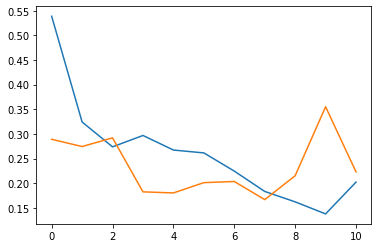

In [80]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [81]:
model_reg.save("multi_inputs_reg_model")

INFO:tensorflow:Assets written to: multi_inputs_reg_model\assets


INFO:tensorflow:Assets written to: multi_inputs_reg_model\assets


In [85]:
X_num_train.shape

(902, 20, 2)

In [86]:
X_fed_lstm_train.shape

(902, 20, 300)

In [92]:
mean_squared_error(y_test_reg, model_reg.predict([X_fed_lstm_test, X_ecb_lstm_test, X_num_test]))**(1/2)

0.4482039670720707

In [ ]:
os.chdir('C:/Users/32mor/OneDrive/Documents/Polytechnique/NLP & Natixis/starting_kit/answer')

In [93]:
def data_expander(
    index='vix', task='classification', test_size=0, 
    price_data=True, speech_data = True, all_data=False,
    validation = False):
    
    if index == 'vix':
        df = pd.read_json('./data/test/VIX_1w.json')
    else: 
        df = pd.read_json('./data/test/EURUSDV1M_1w.json')
    
    # Creation of a df with all the input variables 

    X = pd.DataFrame(index=df.index)

    prices = pd.DataFrame(
            df['stock'].to_list(),
            columns=['price' + str(i) for i in range(1,21)]
            )

    speeches = pd.DataFrame(df['speech'].values.tolist())
    speech_cols = pd.DataFrame(index=speeches.index)

    for i in range(len(speeches.columns)):
        daily = pd.DataFrame(speeches[i].values.tolist())
        daily.columns = [f'ecb{i+1}', f'fed{i+1}']
        speech_cols = speech_cols.join(daily)

    speech_cols = speech_cols.applymap(unpack)

    if price_data:
        X = X.join(prices)
    if speech_data:
        X = X.join(speech_cols)
    
    # Target variable

    if task == 'classification':
        y = df['target_classif']
    else:
        y = df['target_reg']

    # Return entire frame

    if all_data:
        return X, df['target_classif'], df['target_reg']

    # Validation data, stay away

    X_train, X_validation, y_train, y_validation = train_test_split(
            X, y, test_size=0.2, random_state=1)

    if validation:
        return X_train, X_validation, y_train, y_validation

    # Train-test split
    
    if test_size > 0:
        X_train, X_test, y_train, y_test = train_test_split(
            X_train, y_train, test_size=test_size, random_state=1)
        return X_train, X_test, y_train, y_test
    else:
        return X_train, y_train

In [94]:
path = 'C:/Users/32mor/OneDrive/Documents/Polytechnique/NLP & Natixis/starting_kit/data'
os.chdir(path)
X, y_cat, y_reg = hx.data_expander(all_data=True,index='eur')
y = pd.concat([y_cat,y_reg],axis=1)

In [95]:
X_fed_test_final, X_ecb_test_final, X_num_test_final = test_pipe.transform(X)

100%|██████████| 1262/1262 [00:00<00:00, 15389.97it/s]


In [98]:
speeches_test = int(len(X_ecb_test_final)/20)
components = 300
X_fed_lstm_test_final = X_fed_test_final.reshape((speeches_test, day_max, components))
X_ecb_lstm_test_final = X_ecb_test_final.reshape((speeches_test, day_max, components))

In [99]:
y_final_cat_eurusd = model_cat.predict([X_fed_lstm_test_final, X_ecb_lstm_test_final, X_num_test_final])
y_final_reg_eurusd = model_reg.predict([X_fed_lstm_test_final, X_ecb_lstm_test_final, X_num_test_final])

In [104]:
os.getcwd()

'C:\\Users\\32mor\\OneDrive\\Documents\\Polytechnique\\NLP & Natixis\\starting_kit\\data\\answers'

In [102]:
os.mkdir('answers')
os.chdir('answers')

In [103]:
os.mkdir('VIX_1w')
os.mkdir('EURUSDV1M_1w')

In [105]:
# np.savetxt('./VIX_1w/pred_reg.txt', vix_reg, fmt='%.3f')
# np.savetxt('./VIX_1w/pred_classif.txt', vix_class, fmt='%d')
np.savetxt('./EURUSDV1M_1w/pred_reg.txt', y_final_reg_eurusd, fmt='%.3f')
np.savetxt('./EURUSDV1M_1w/pred_classif.txt', y_final_cat_eurusd, fmt='%d')